In [1]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ParameterGrid
import random
import math
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import time
import torch.nn.functional as F

In [2]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(use_cuda)

random.seed(0)

True


In [ ]:
data_folder = "Data"
problem_case = "fixed_base"

if problem_case == "fixed_base":
    folder_path = os.path.join(data_folder, "Fixed_Base_Moment_Frame")
elif problem_case == "base_isolated":
    folder_path = os.path.join(data_folder, "Base_Isolated_Moment_Frame_without_Impact")
else:
    raise Exception("Problem type not supported")

#  Define columns 
time_column = 'Time'
predictor_columns = ['aextx']
target_columns = ['ACCs2', 'ACCs3', 'ACCs4', 'ACCs5']

all_data = []
combined_data = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(folder_path, file_name)
        try:
            df = pd.read_csv(file_path, sep=r'\s+', engine='python')
            if all(col in df.columns for col in predictor_columns + target_columns + [time_column]):
                df_clean = df[[time_column] + predictor_columns + target_columns].dropna()
                all_data.append((df_clean, file_name))
                combined_data.append(df_clean)
        except Exception as e:
            print(f"Failed to read {file_name}: {e}")

In [4]:
# Choose a file for validation
print(len(all_data))
print(len(combined_data))
ind_valid = random.randrange(len(all_data))
df_valid, file_valid = all_data.pop(ind_valid)
combined_data.pop(ind_valid)
print(file_valid)
print(len(all_data))
print(len(combined_data))

9
9
filtered_fbgm162s1_denoised.txt
8
8


In [5]:
def split_into_sequences(df, predictor_columns, target_columns, seq_len, stride):
    N = len(df)
    x = []
    y = []
    for i in range(0, N-seq_len+1, stride):
        x.append(torch.tensor(df[predictor_columns].values[i:i+seq_len], dtype=torch.float))
        y.append(torch.tensor(df[target_columns].values[i:i+seq_len], dtype=torch.float))
    x = torch.stack(x)
    y = torch.stack(y)
    return x, y

In [6]:
all_x = []
all_y = []
seq_len = 500
stride = 5

for df in combined_data:
    x, y = split_into_sequences(df, predictor_columns, target_columns, seq_len, stride)
    print(x.shape, y.shape)
    all_x.append(x)
    all_y.append(y)
    
x = torch.cat(all_x)
y = torch.cat(all_y)
print(x.shape, y.shape)

torch.Size([2191, 500, 1]) torch.Size([2191, 500, 4])
torch.Size([2111, 500, 1]) torch.Size([2111, 500, 4])
torch.Size([2027, 500, 1]) torch.Size([2027, 500, 4])
torch.Size([2176, 500, 1]) torch.Size([2176, 500, 4])
torch.Size([2098, 500, 1]) torch.Size([2098, 500, 4])
torch.Size([2129, 500, 1]) torch.Size([2129, 500, 4])
torch.Size([2168, 500, 1]) torch.Size([2168, 500, 4])
torch.Size([2155, 500, 1]) torch.Size([2155, 500, 4])
torch.Size([17055, 500, 1]) torch.Size([17055, 500, 4])


In [7]:
batch_size = 64
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# Create Tensor Datasets
trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

torch.Size([13644, 500, 1])
torch.Size([13644, 500, 4])
torch.Size([3411, 500, 1])
torch.Size([3411, 500, 4])


In [8]:
class LSTMModel(nn.Module):
    # num_layers: The number of layers in the LSTM.
    # input_dim: Input dimension of the data.
    # hidden_dim: Hidden dimension for the LSTM.  
    # output_dim: Output dimension of the data. 
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim, dropout=0.1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    # x=(batch_size, seq_len, input_dim)
    def forward(self, x):
        output, _ = self.lstm(x)
        x = self.linear(output)
        return x

In [9]:
def trainer(model, trainData, testData, learning_rate, step_size, epochs, output_rate, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    loss = torch.nn.MSELoss()
    for ep in range(epochs):
        model.train()
        train_loss = 0
        for x_vals, y_vals in trainData:
            x_vals, y_vals = x_vals.to(device), y_vals.to(device)
            optimizer.zero_grad()
            out = model(x=x_vals)
            lp = loss(out, y_vals)
            lp.backward()
                
            optimizer.step()
            train_loss += lp.item()
    
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                x_vals, y_vals = x_vals.to(device), y_vals.to(device)
                out = model(x=x_vals)
                test_loss += loss(out, y_vals).item()
        train_loss /= len(trainData)
        test_loss /= len(testData)
        if ep%output_rate == 0:
                print(ep, train_loss, test_loss)
    return model

def test_model(testData, model, tol):
    model.eval()
    loss= torch.nn.MSELoss()
    with torch.no_grad():
        test_loss = 0
        for x_vals, y_vals in testData:
            out = model(x=x_vals)
            test_loss += loss(out, y_vals).item()
        test_loss /= len(testData)
    print(test_loss)

In [10]:
def run_grid_search(input_dim, output_dim, epochs, best_model_path, best_params_path, device):
    # Perform Hyperparameter Grid Search
    param_grid = {
        'hidden_dim': [32, 64, 128],
        'num_layers': [2, 3],
        'dropout': [0.1, 0.2],
        'lr': [0.001, 0.005]
    }

    best_loss = float('inf')
    best_model = None
    best_params = None

    for params in ParameterGrid(param_grid):
        model = LSTMModel(input_dim=input_dim, hidden_dim=params['hidden_dim'], num_layers=params['num_layers'],
                           dropout=params['dropout'], output_dim=output_dim)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs, gamma=0.5)
        
        for epoch in range(epochs):
            model.train()
            for x_vals, y_vals in trainData:
                x_vals, y_vals = x_vals.to(device), y_vals.to(device)
                optimizer.zero_grad()
                output = model(x_vals)
                loss = criterion(output, y_vals)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            scheduler.step()
    
        model.eval()
        val_loss = np.mean([criterion(model(x_vals.to(device)), y_vals.to(device)).item() for x_vals, y_vals in testData])
        print(f"Params: {params}, Test MSE: {val_loss}")
    
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = params
    
    torch.save(best_model.state_dict(), best_model_path)
    torch.save(best_params, best_params_path)
    print("Best Model Saved")
    print(f"Best Params: {best_params}, Best Test MSE: {best_loss}")

    return best_model, best_params

In [ ]:
input_dim = len(predictor_columns)
output_dim = len(target_columns)

best_model_path = f"Model/best_lstm_model_{problem_case}.pth"
best_params_path = f"Model/best_lstm_params_{problem_case}.pth"
if os.path.isfile(best_model_path) and os.path.isfile(best_params_path):
    best_params = torch.load(best_params_path)

    best_model = LSTMModel(input_dim=input_dim, hidden_dim=best_params['hidden_dim'], num_layers=best_params['num_layers'],
                           dropout=best_params['dropout'], output_dim=output_dim)
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(best_model_path))
    print(f"Best Params: {best_params}")
    print("Loaded model from file")
else:
    epochs = 50
    best_model, best_params = run_grid_search(input_dim, output_dim, epochs, best_model_path, best_params_path, device)
    print("Ran grid search")

Loaded model from file


In [12]:
model = LSTMModel(input_dim=input_dim, hidden_dim=best_params['hidden_dim'], num_layers=best_params['num_layers'],
                       dropout=best_params['dropout'], output_dim=output_dim)
model = model.to(device)
model.load_state_dict(torch.load(best_model_path))
# Define your set of parameters
epochs = 50 
learning_rate = best_params['lr']
step_size= 10
output_rate = 5

model = trainer(model, trainData, testData, learning_rate, step_size, epochs, output_rate, device)

0 0.00011408469301692502 0.00013915288723688314
5 0.00010706297461668064 0.00012100253937845721
10 8.133650199027631e-05 0.00010446741469894294
15 7.489923037635924e-05 9.920254362643593e-05
20 6.750448466217141e-05 9.737758002167404e-05
25 6.422746875580394e-05 9.706430618852782e-05
30 6.03197509135668e-05 9.563135656073293e-05
35 5.798061144313553e-05 9.490355050392854e-05
40 5.631195663482116e-05 9.353509621077037e-05
45 5.5301911233302543e-05 9.446628522440463e-05


In [ ]:
final_model_path = f"Model/final_lstm_model_{problem_case}.pth"
torch.save(model.state_dict(), final_model_path)
print("Final Model Saved")

Final Model Saved


In [14]:
def plot_results(model, df, folder_path, file_name, device):
    file_path = os.path.join(folder_path, file_name)
    x_example = torch.tensor(df[predictor_columns].values, dtype=torch.float).to(device)
    y_example = torch.tensor(df[target_columns].values, dtype=torch.float).to(device)

    y_pred = model(x_example)
    loss = F.mse_loss(y_pred, y_example)
    print(f"MSE Loss: {loss}")

    fig, axs = plt.subplots(2, 2, sharex=True, figsize=(20,10))
    fig.suptitle(file_path)
    for i in range(len(target_columns)):
        target = target_columns[i]
        axs[i//2, i%2].plot(df[time_column], y_example[:, i].cpu(), label='Real data')
        axs[i//2, i%2].plot(df[time_column], y_pred[:, i].cpu(), label='Predicted data of LSTM')
        axs[i//2, i%2].set_title(f'Prediction of LSTM {target} & Real {target}')
        axs[i//2, i%2].set_xlabel(f'{time_column}')
        axs[i//2, i%2].set_ylabel('Sensor data')
        axs[i//2, i%2].legend()
    plt.show()

Plot the predictions with the final model
Plots for seen data
MSE Loss: 2.780714339678525e-06


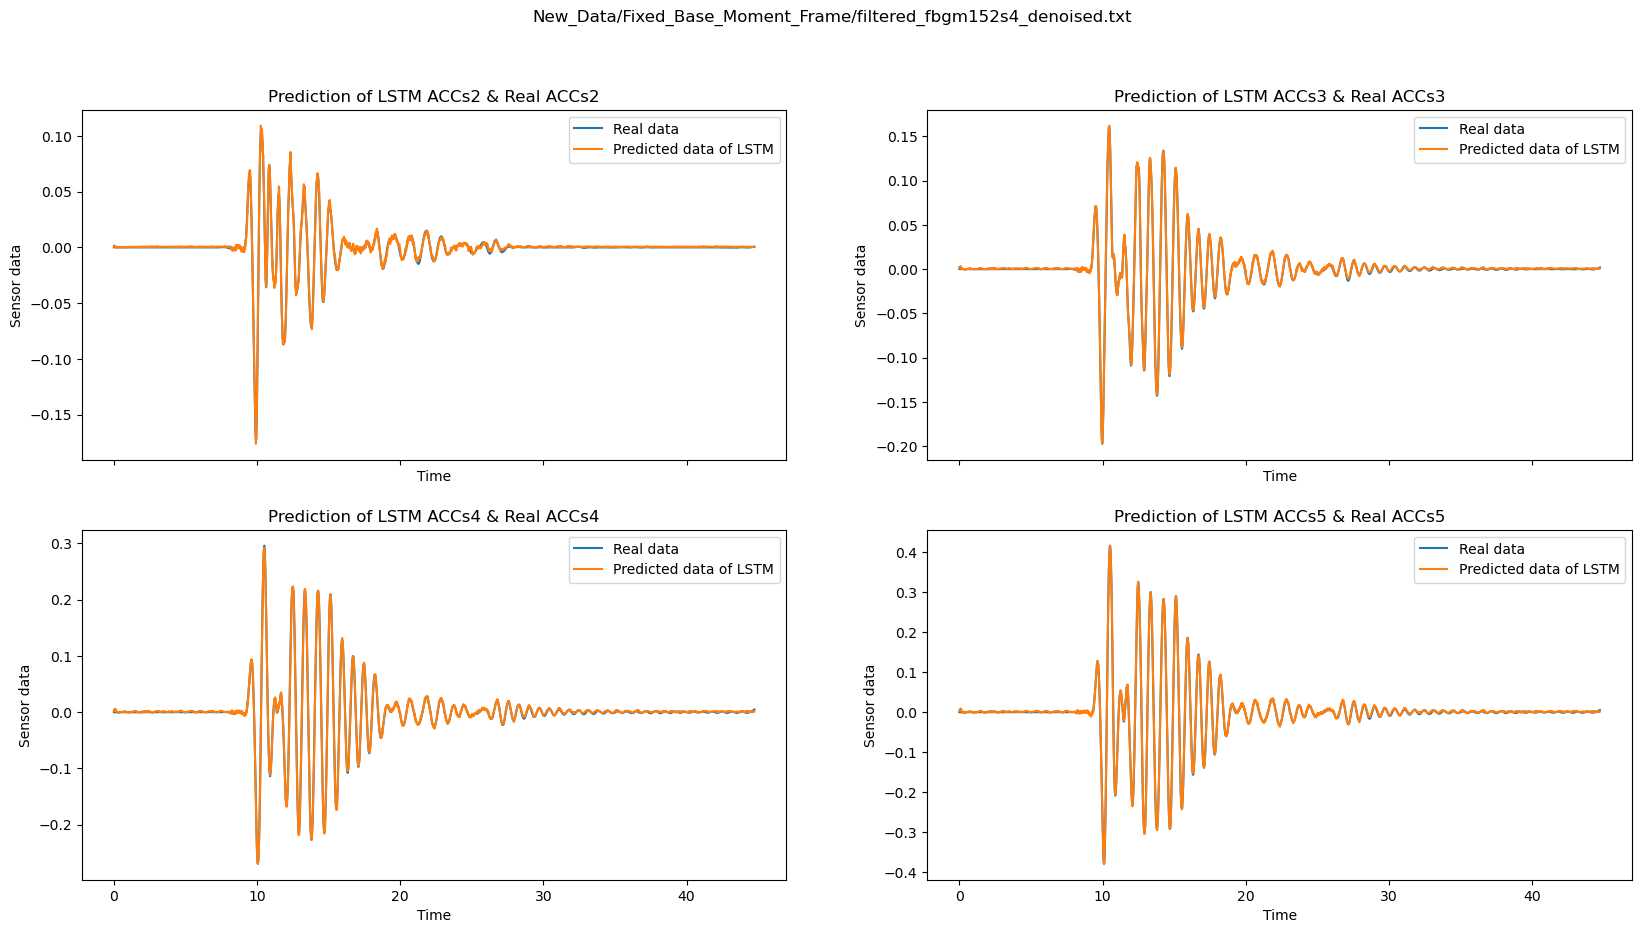

MSE Loss: 1.5867767615418416e-06


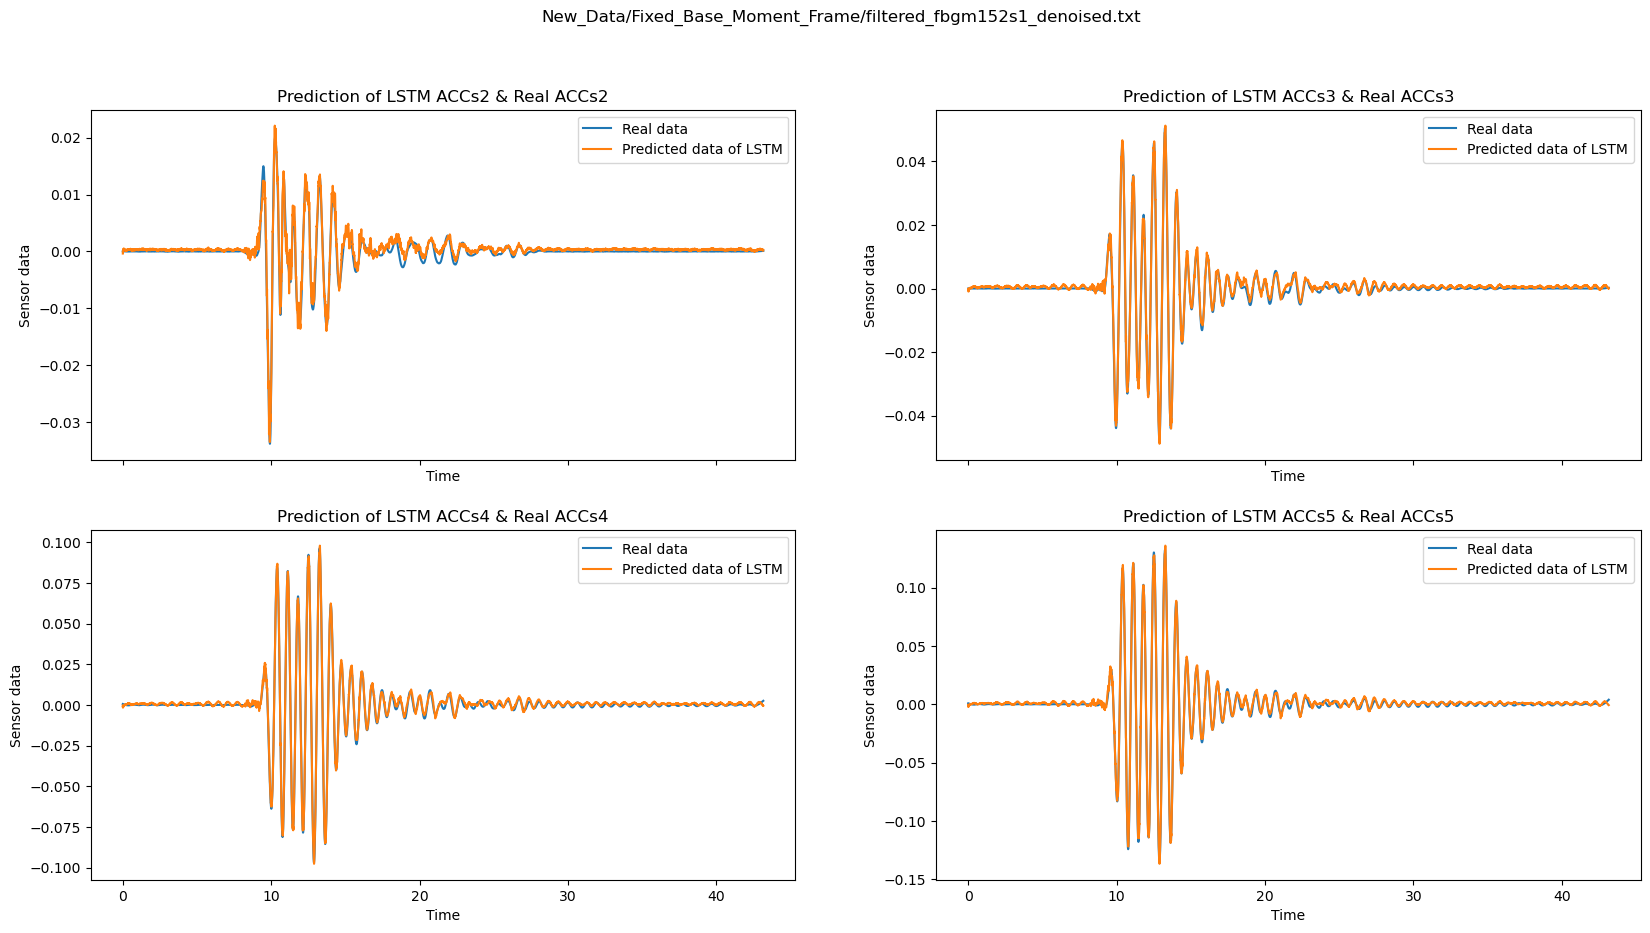

MSE Loss: 1.8255341274198145e-06


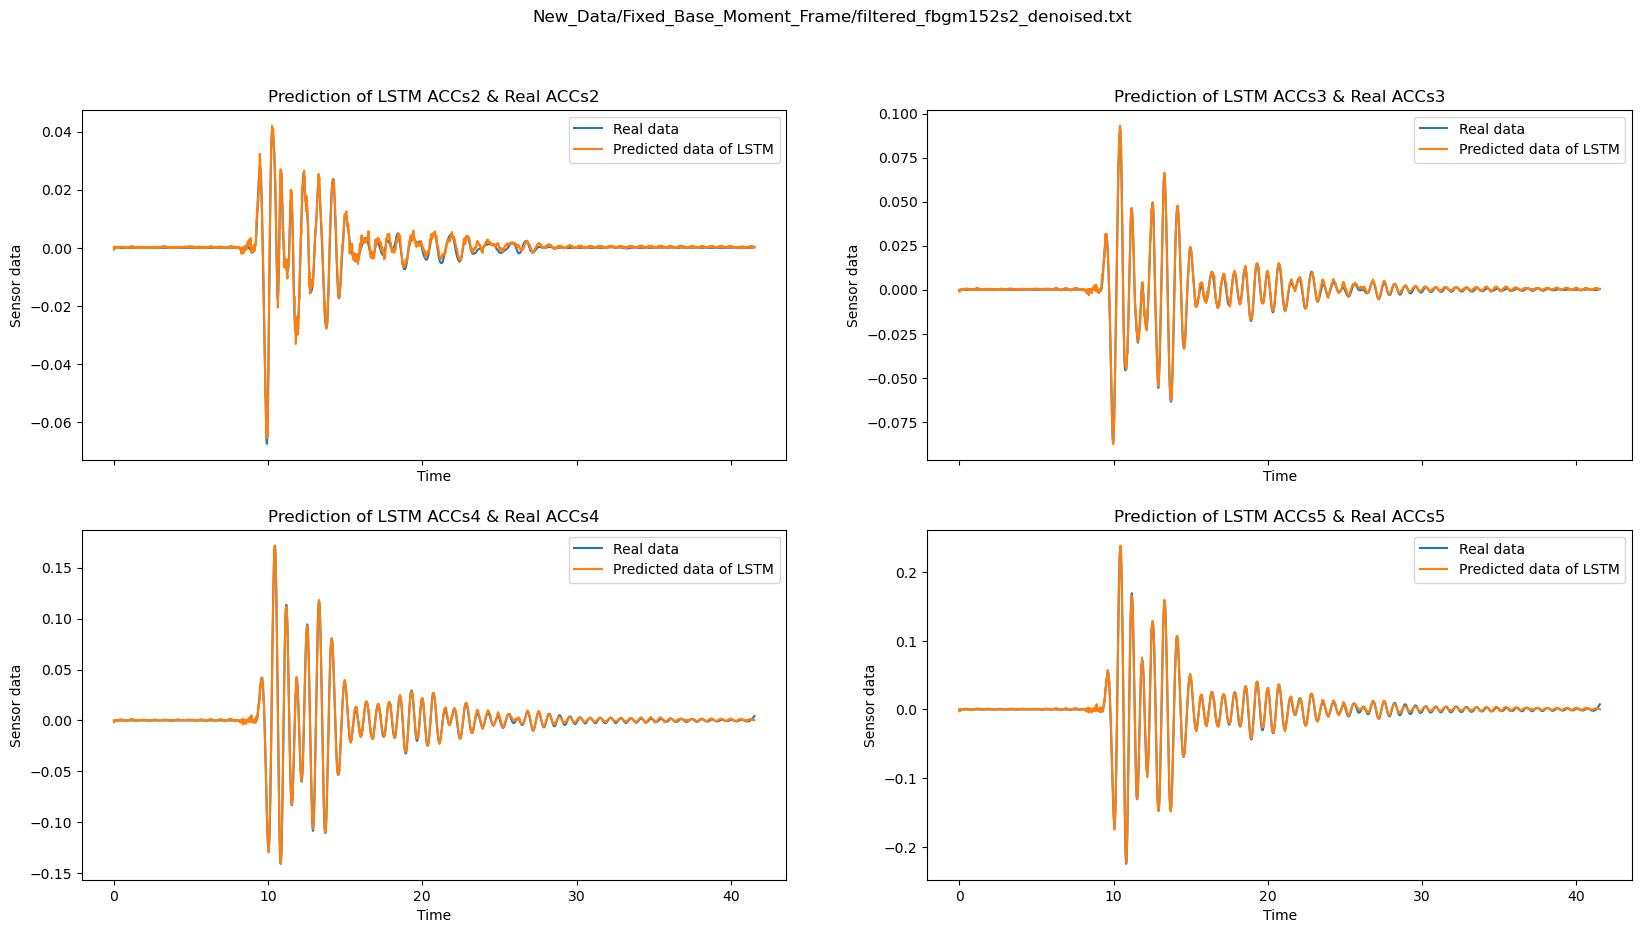

MSE Loss: 2.2801634713687235e-06


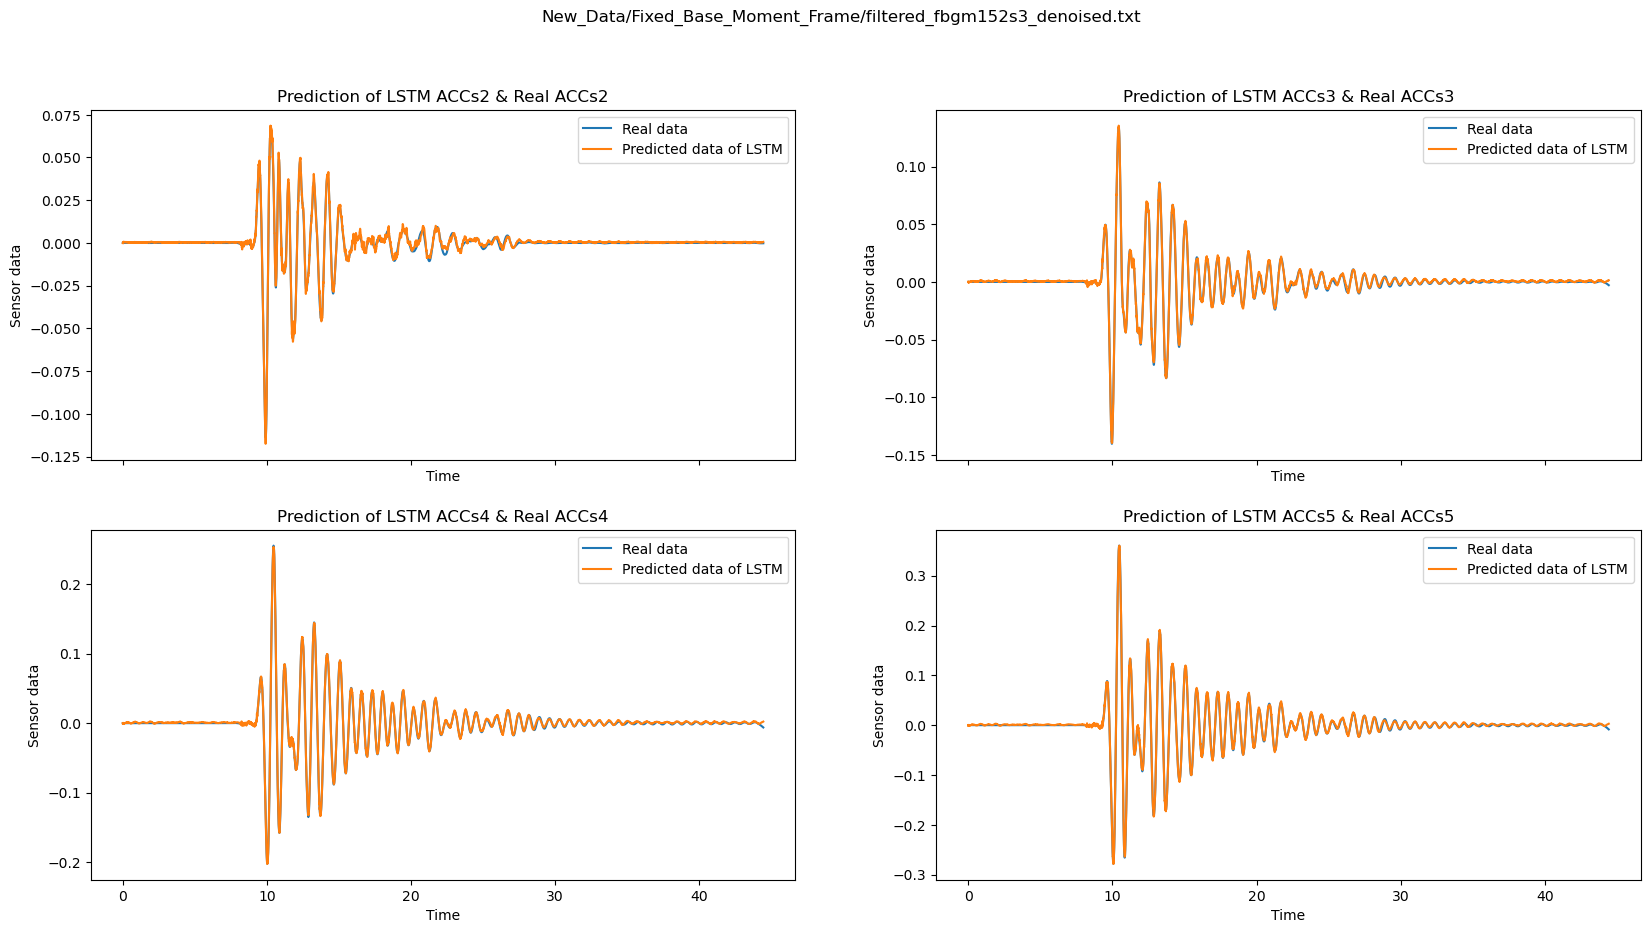

MSE Loss: 2.362577561143553e-06


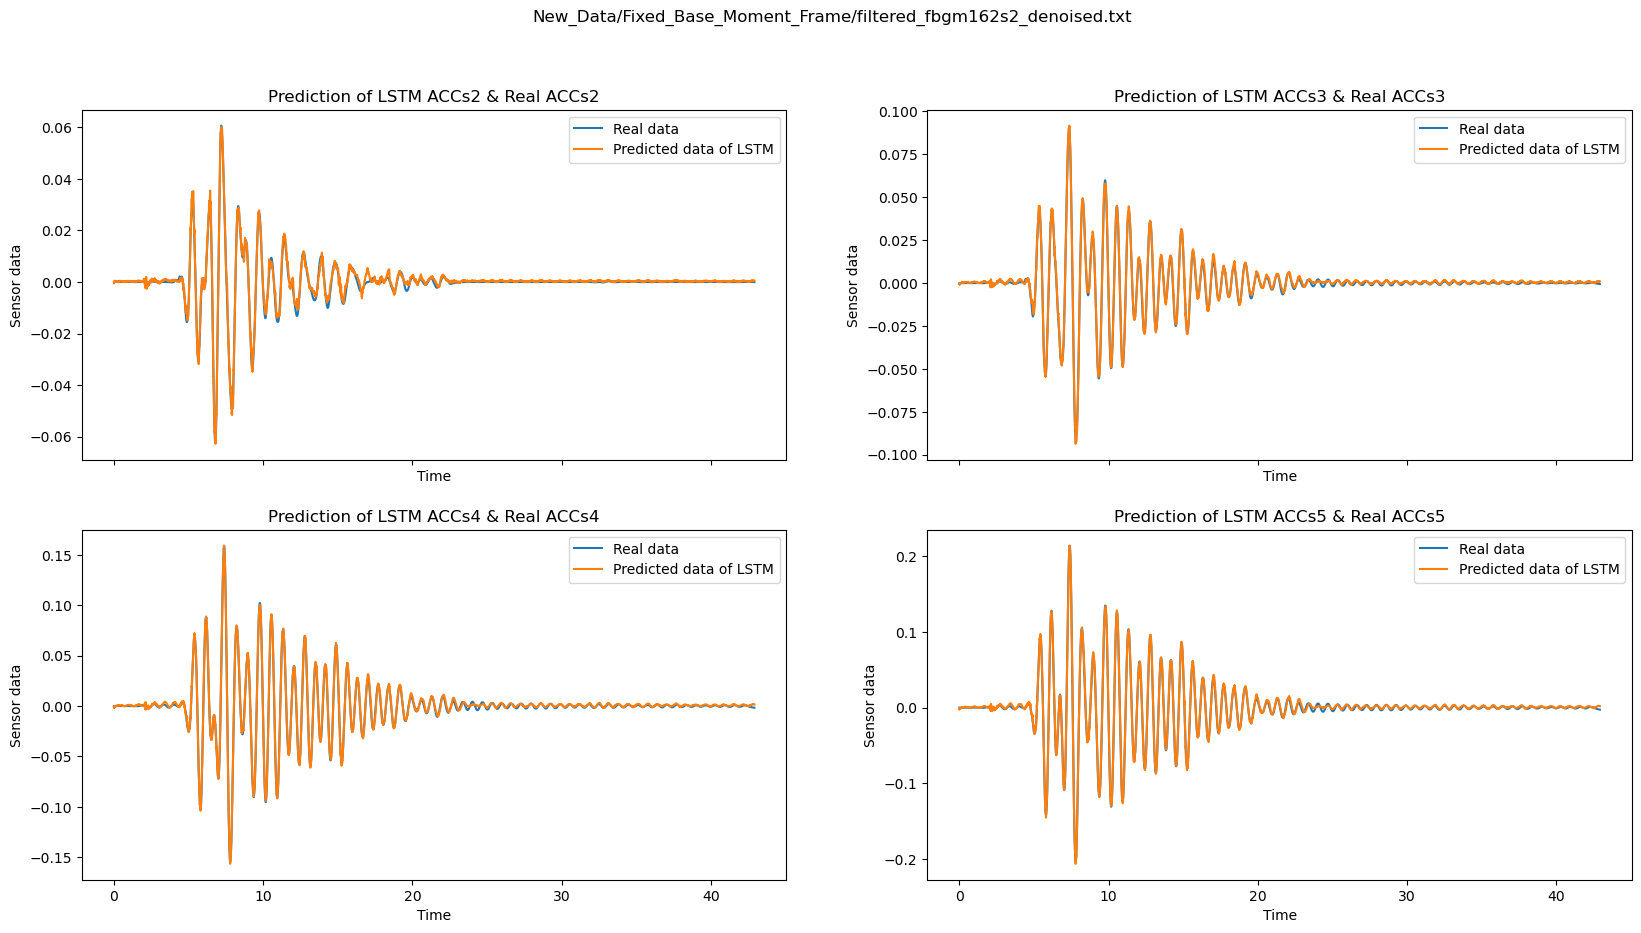

MSE Loss: 2.1312705484888284e-06


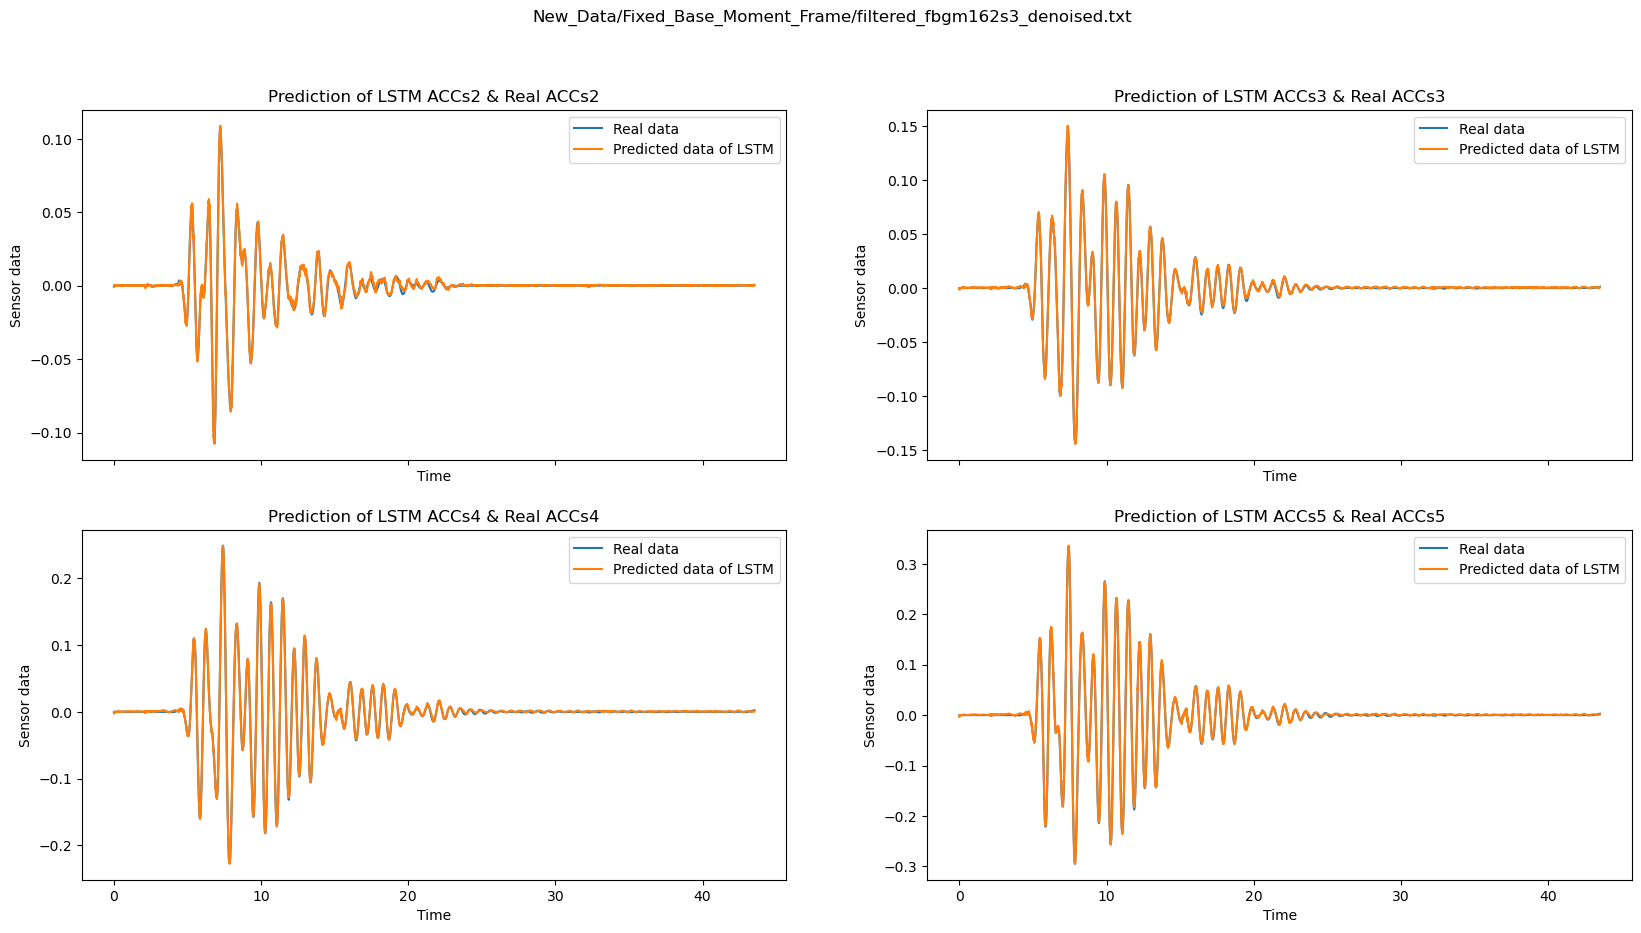

MSE Loss: 2.9328659820748726e-06


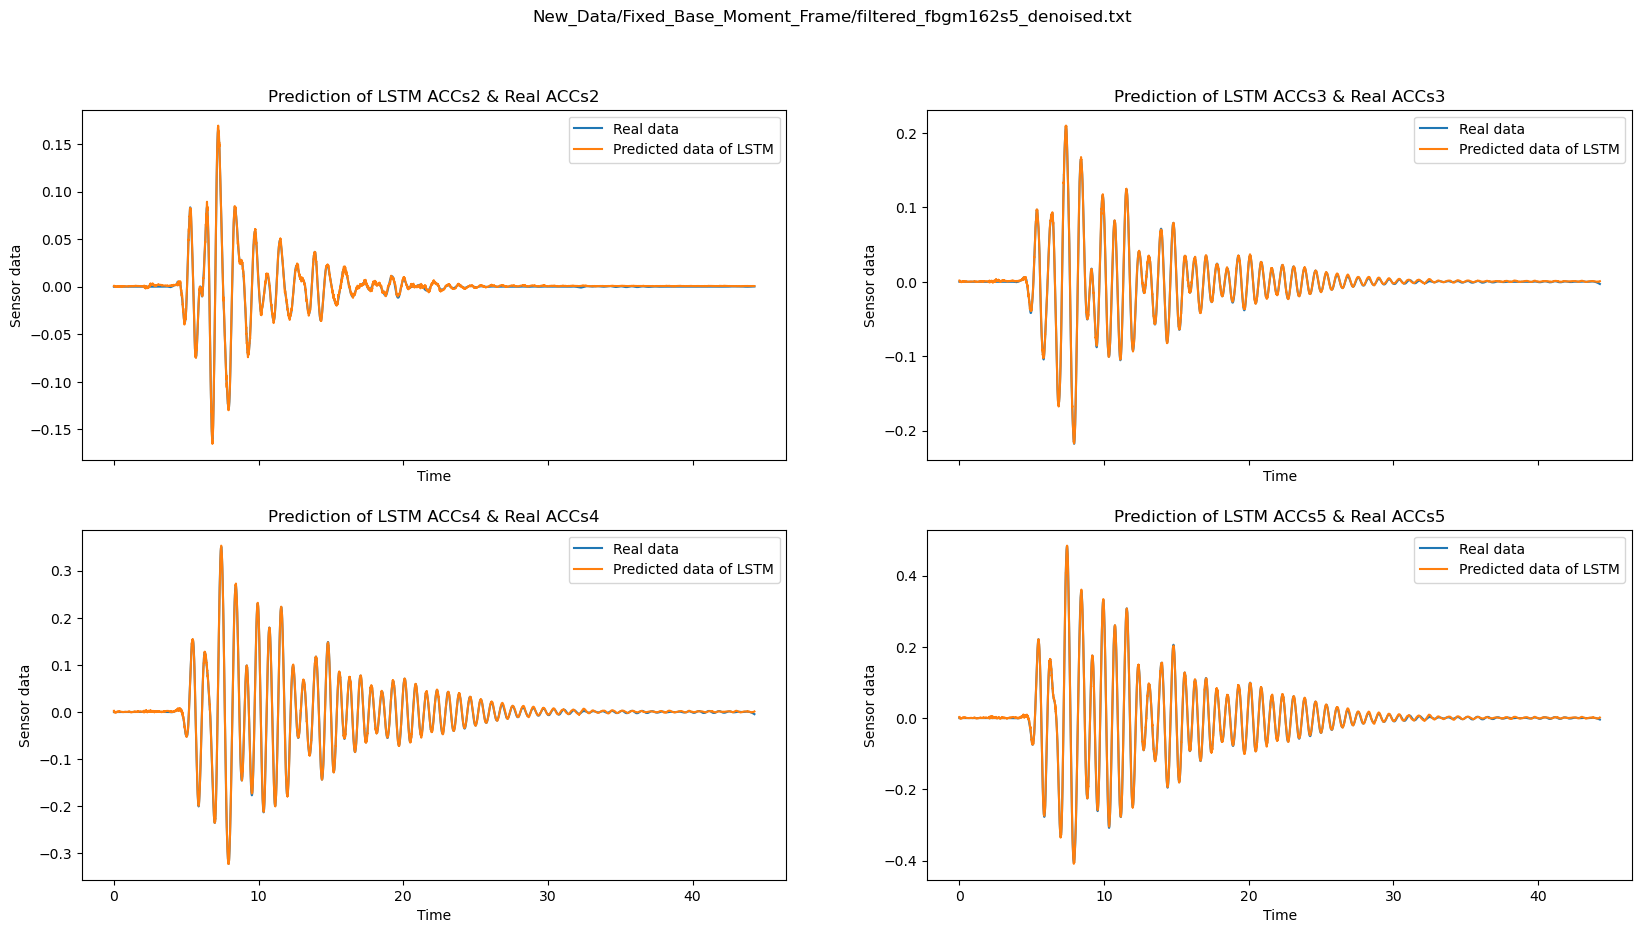

MSE Loss: 3.0698531645612093e-06


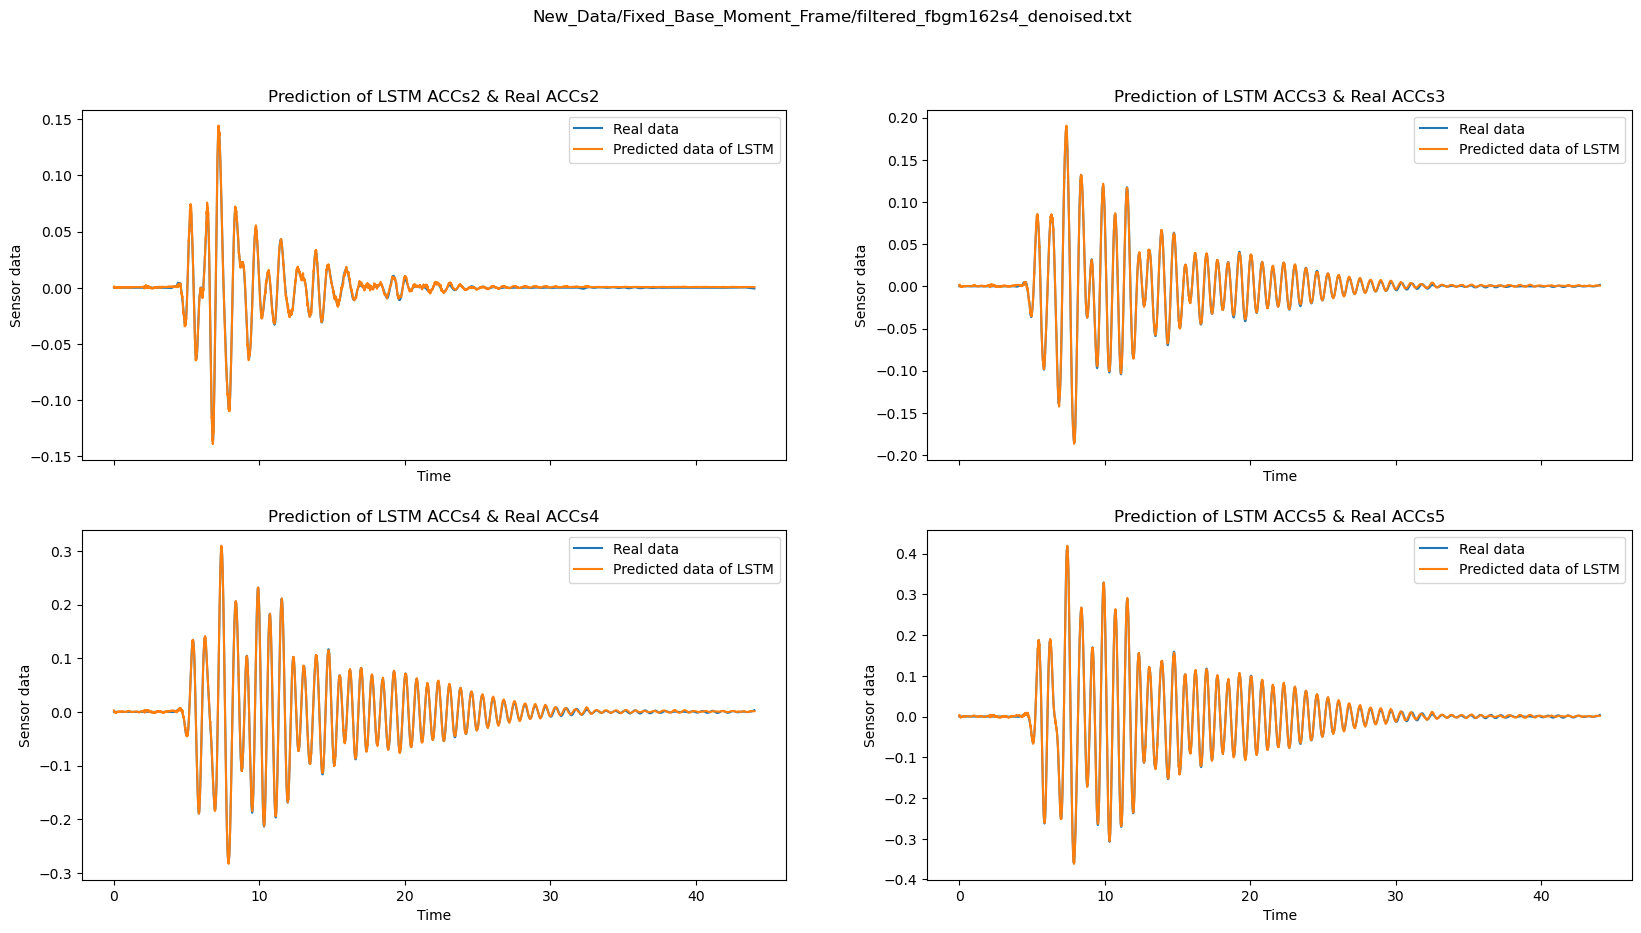

Plots for unseen data
File excluded from training data - filtered_fbgm162s1_denoised.txt
MSE Loss: 0.00020712312834803015


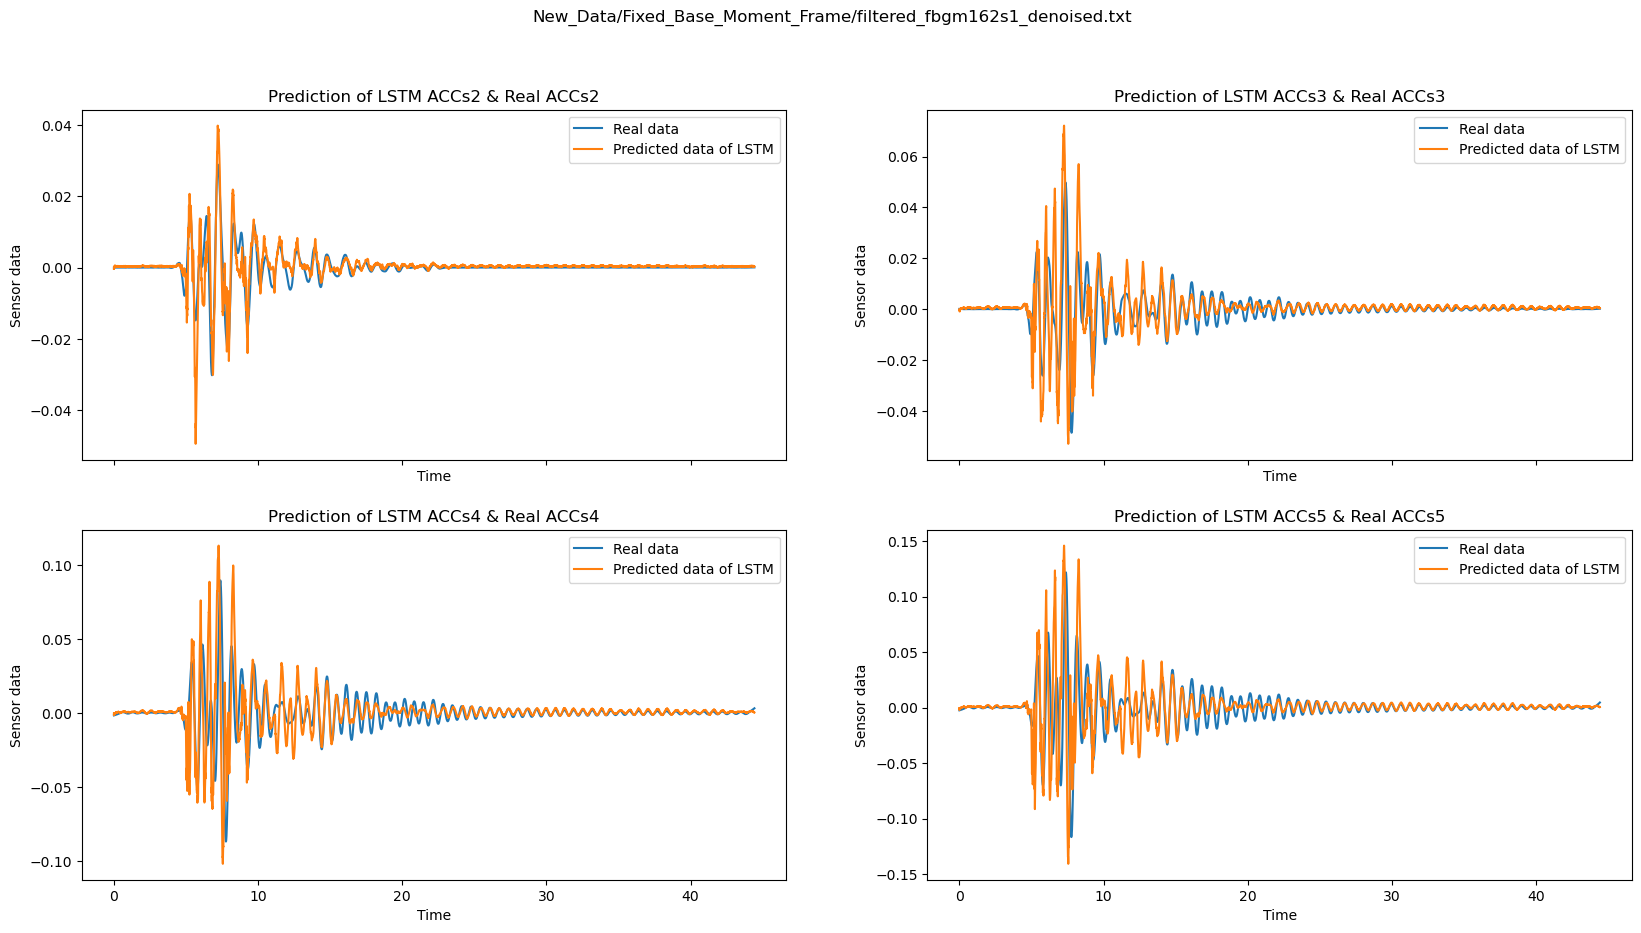

In [15]:
print("Plot the predictions with the final model")
with torch.no_grad():
    print("Plots for seen data")
    for df, file_name in all_data:
        plot_results(model, df, folder_path, file_name, device)

    print("Plots for unseen data")
    print(f"File excluded from training data - {file_valid}")
    plot_results(model, df_valid, folder_path, file_valid, device)
    

Plot the predictions with the best model from grid search
Plots for seen data
MSE Loss: 2.080937338178046e-05


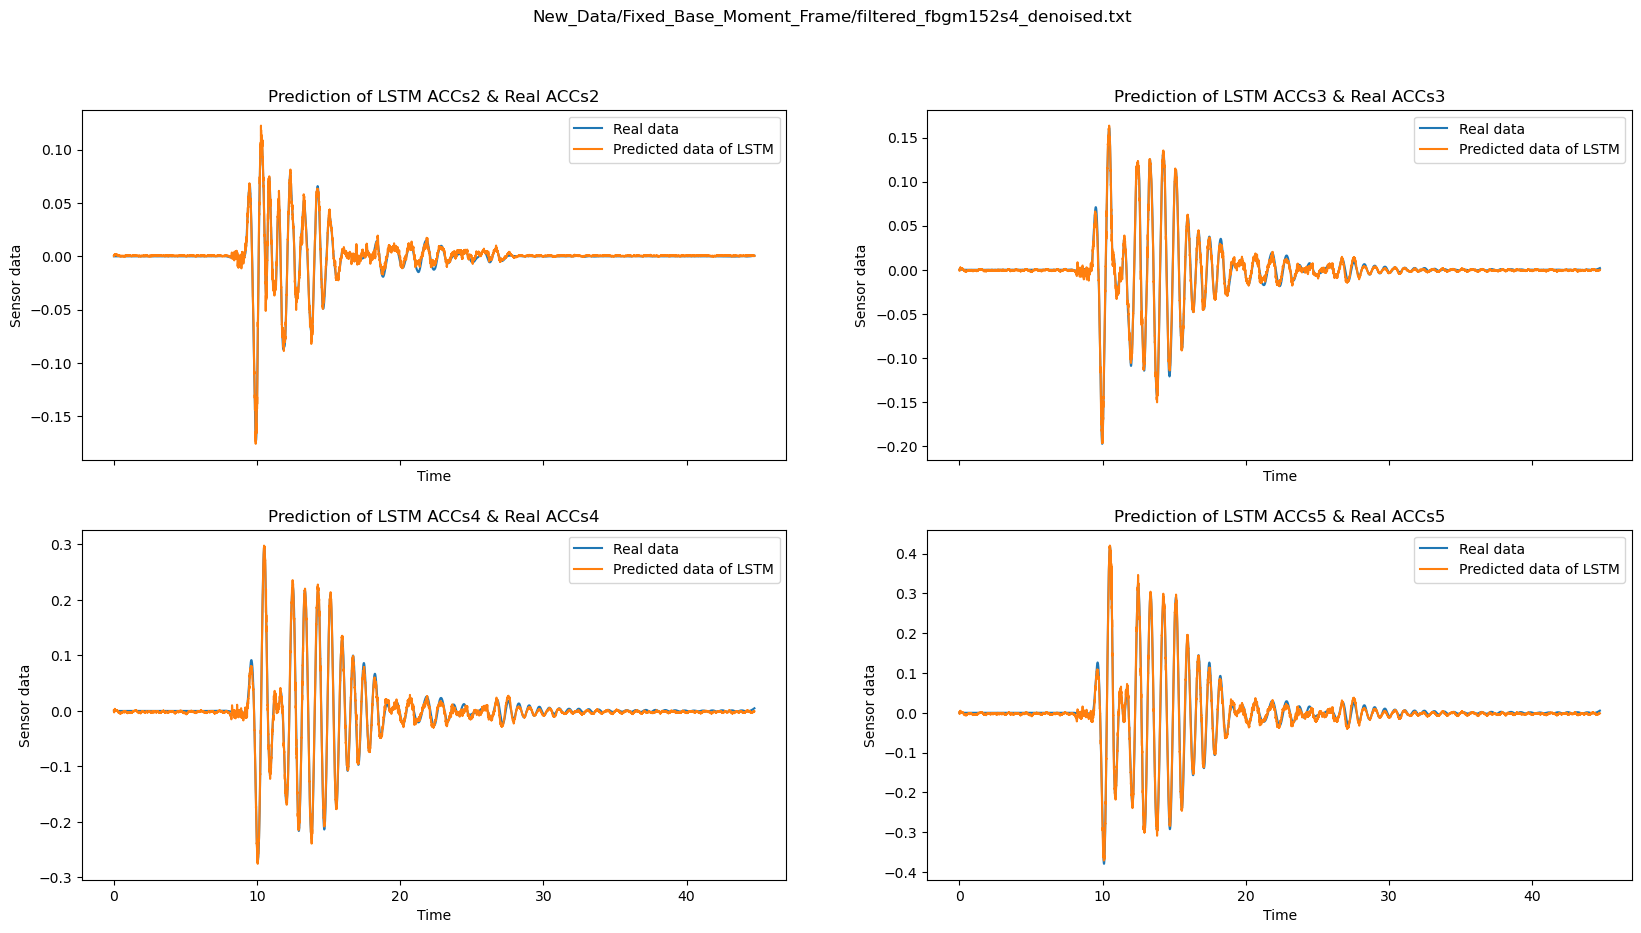

MSE Loss: 1.0298628694727086e-05


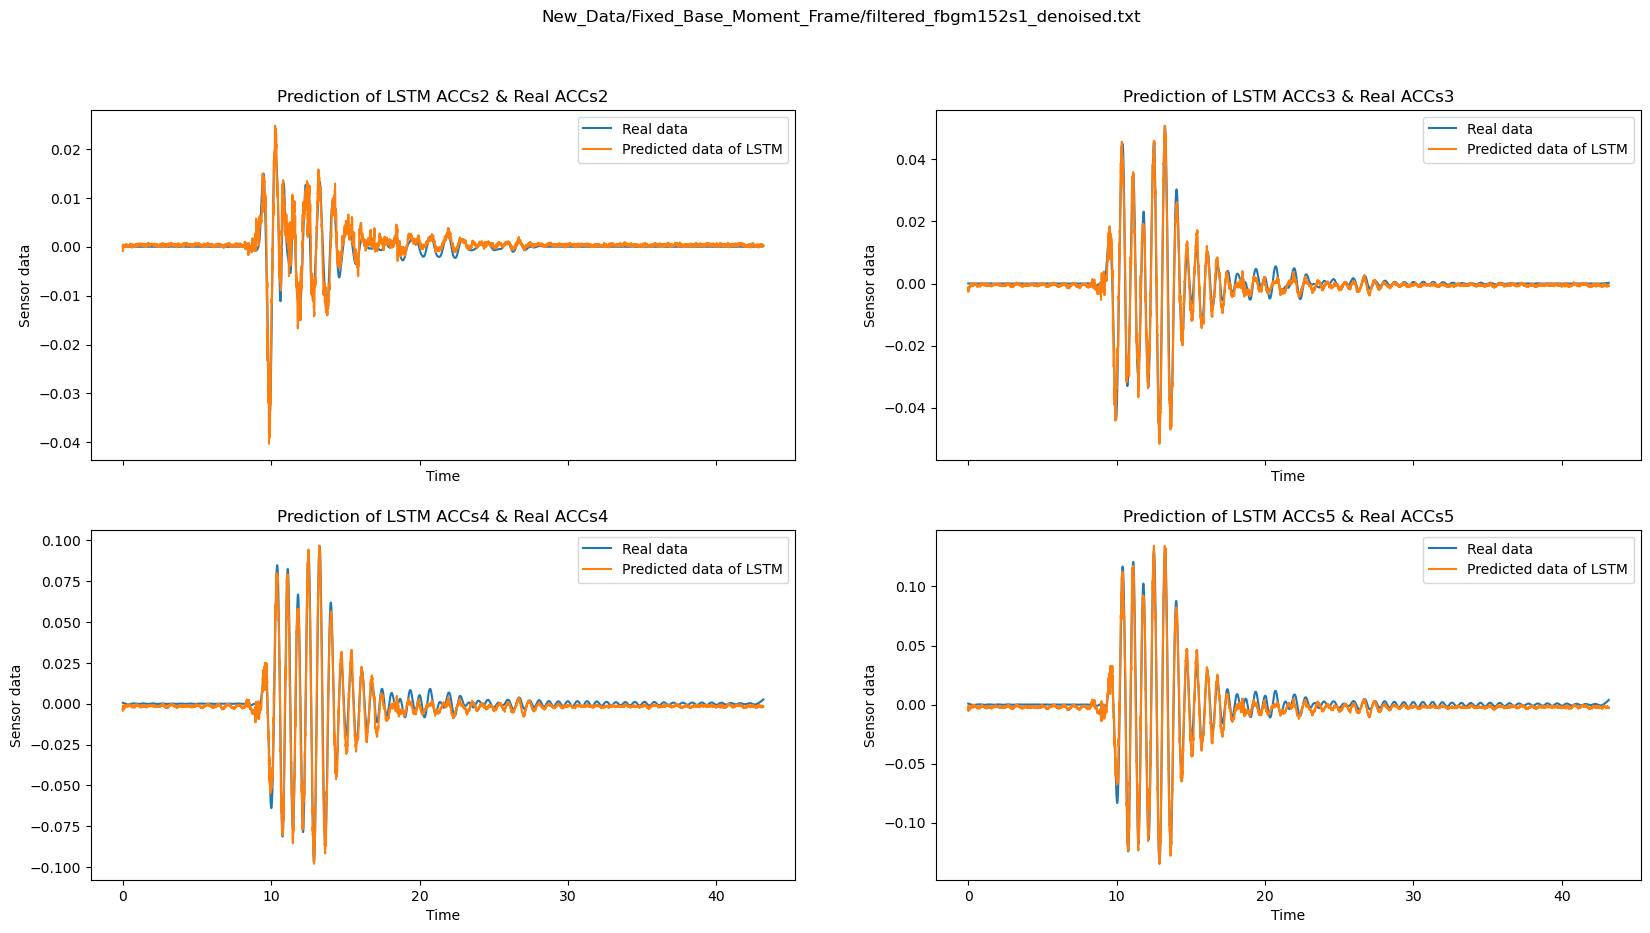

MSE Loss: 1.603115742909722e-05


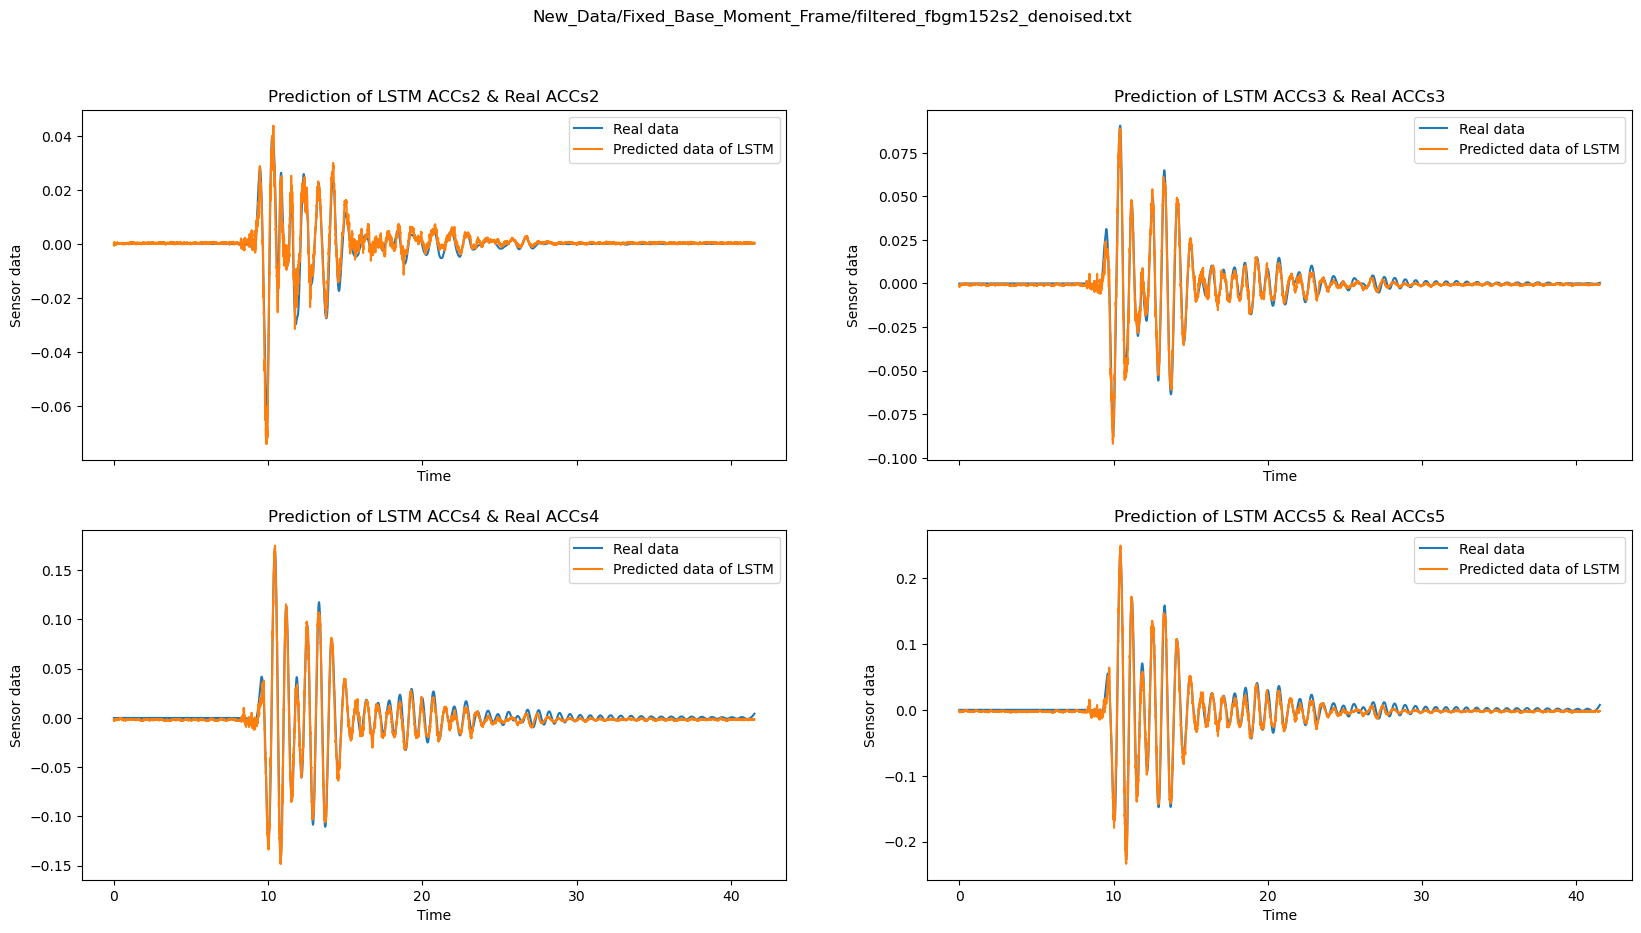

MSE Loss: 1.541226083645597e-05


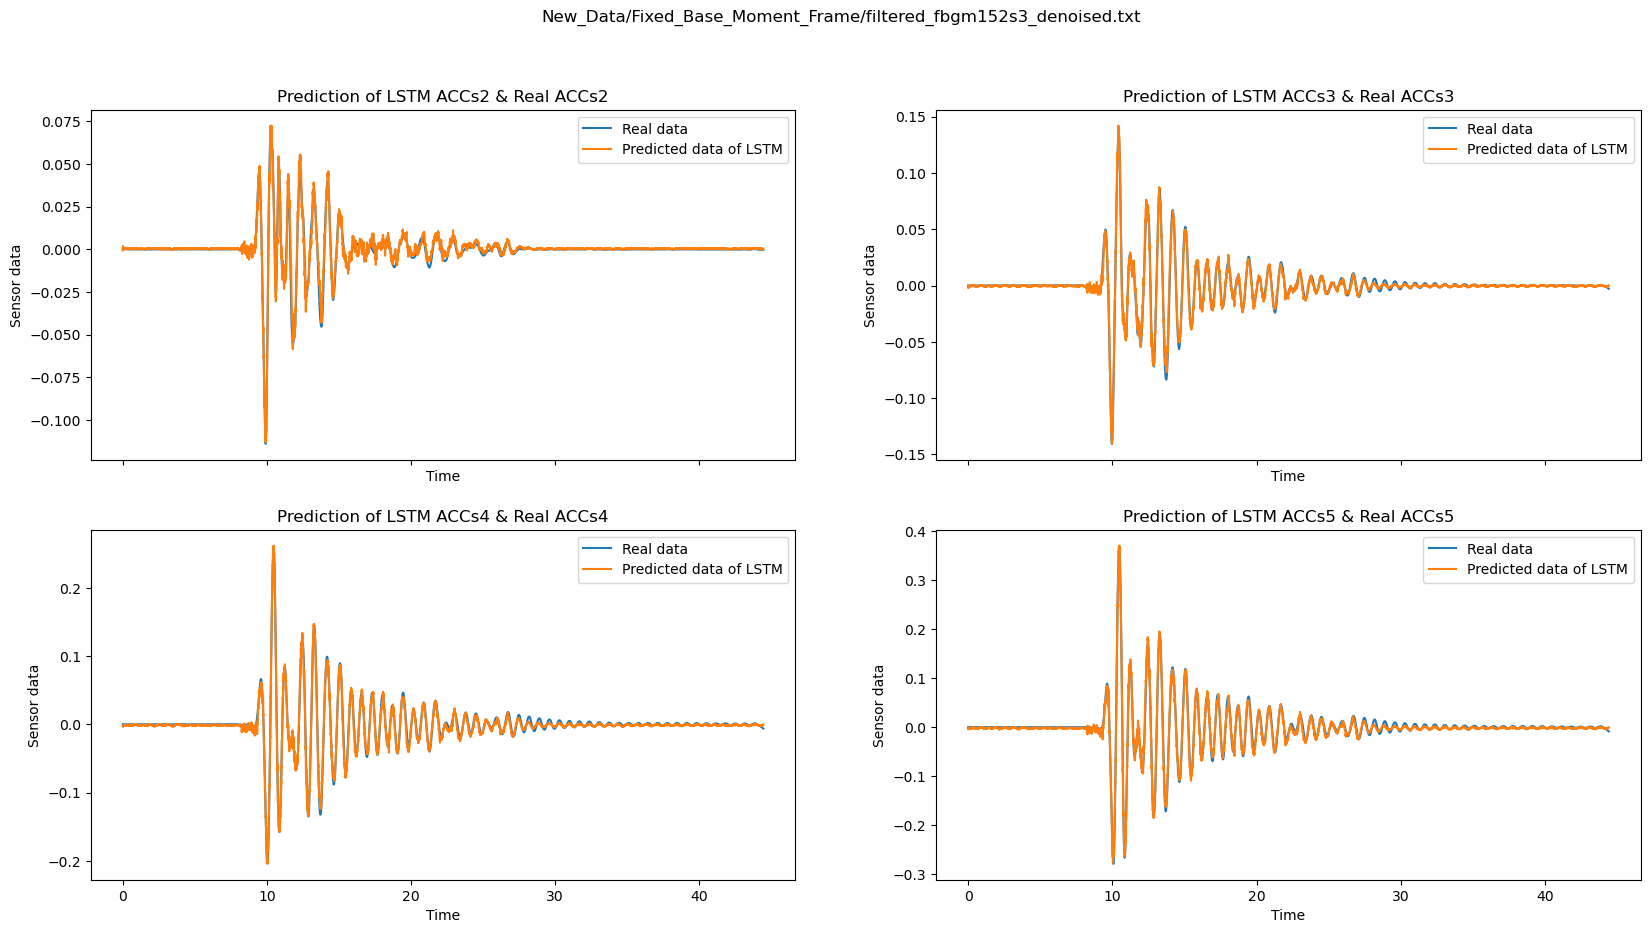

MSE Loss: 1.767530011420604e-05


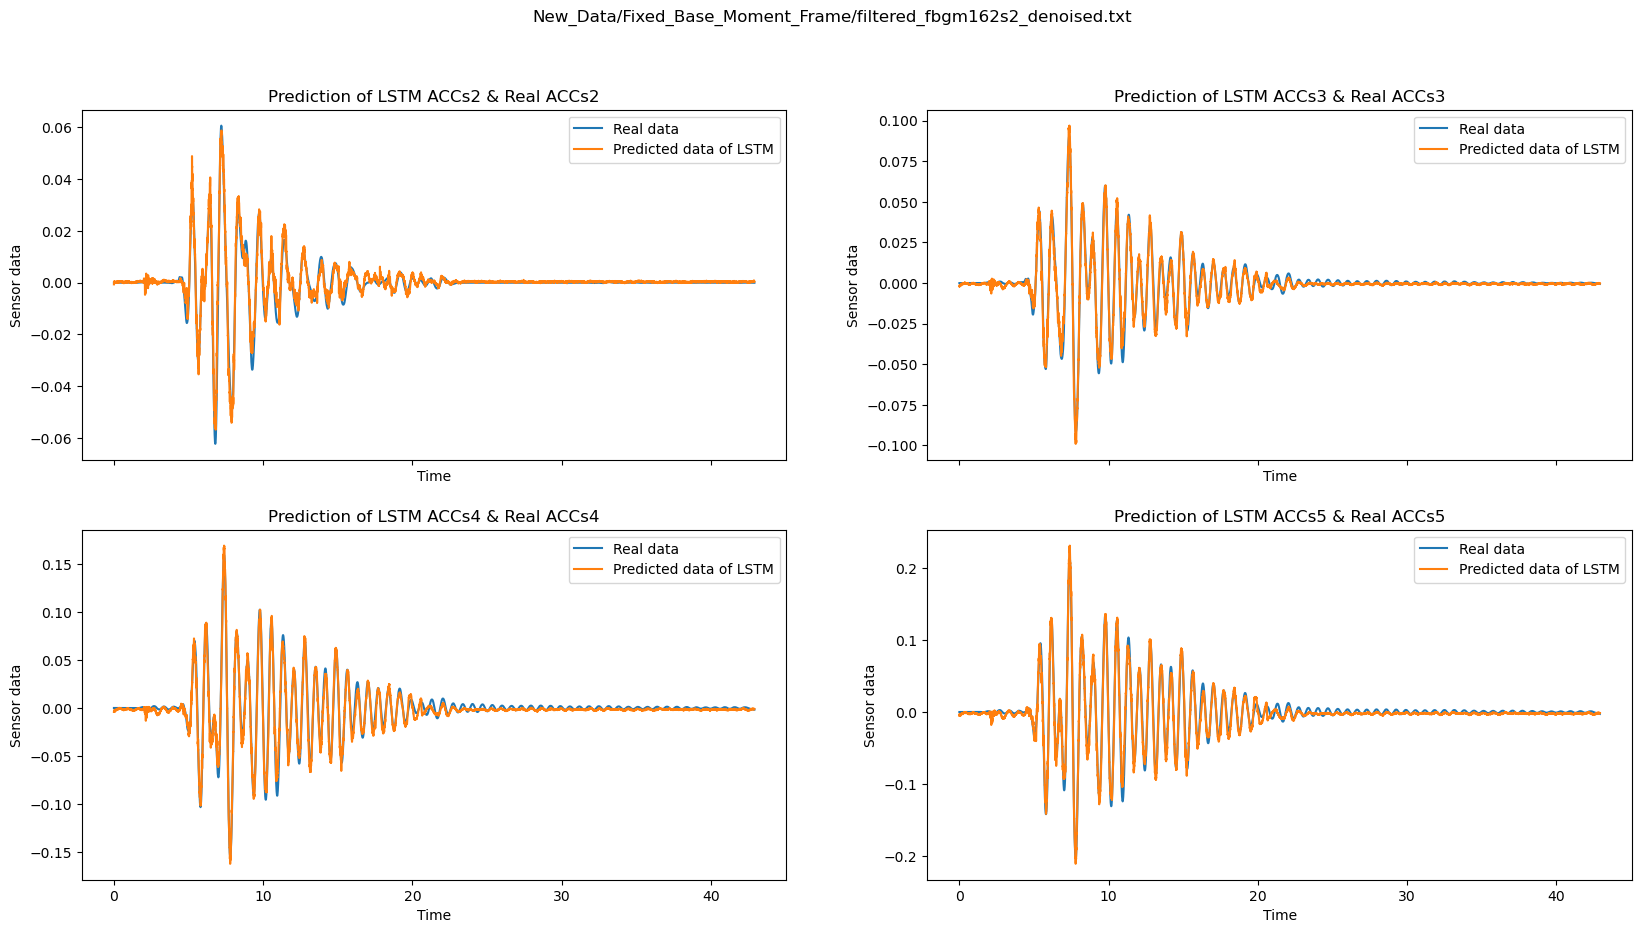

MSE Loss: 1.7880749510368332e-05


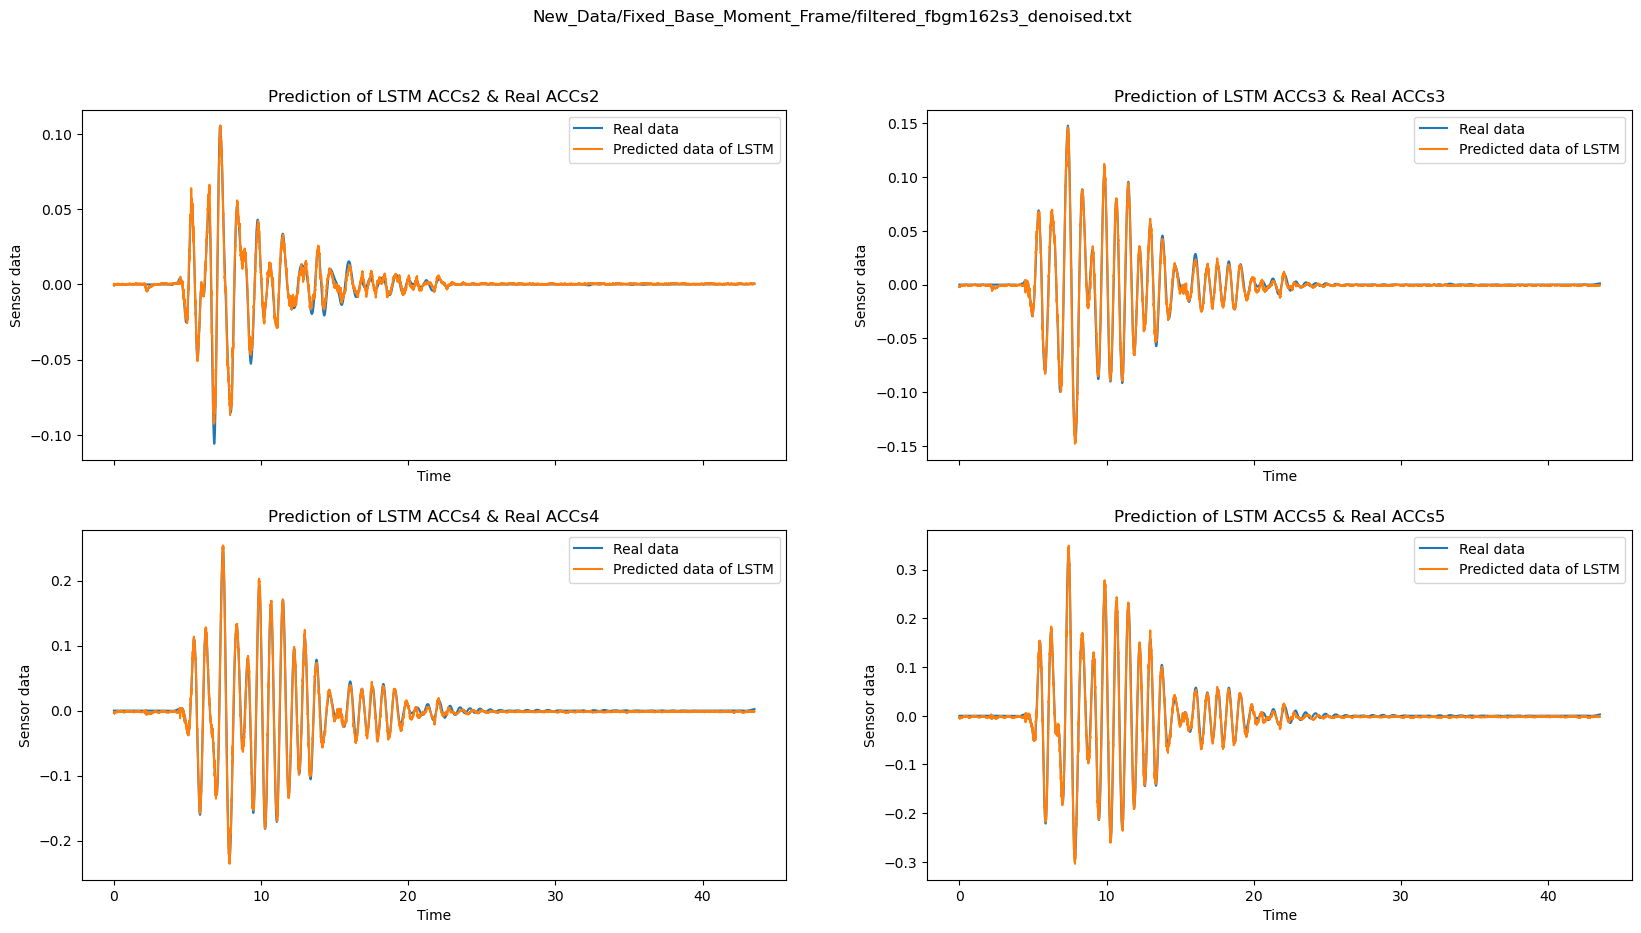

MSE Loss: 2.2960733986110426e-05


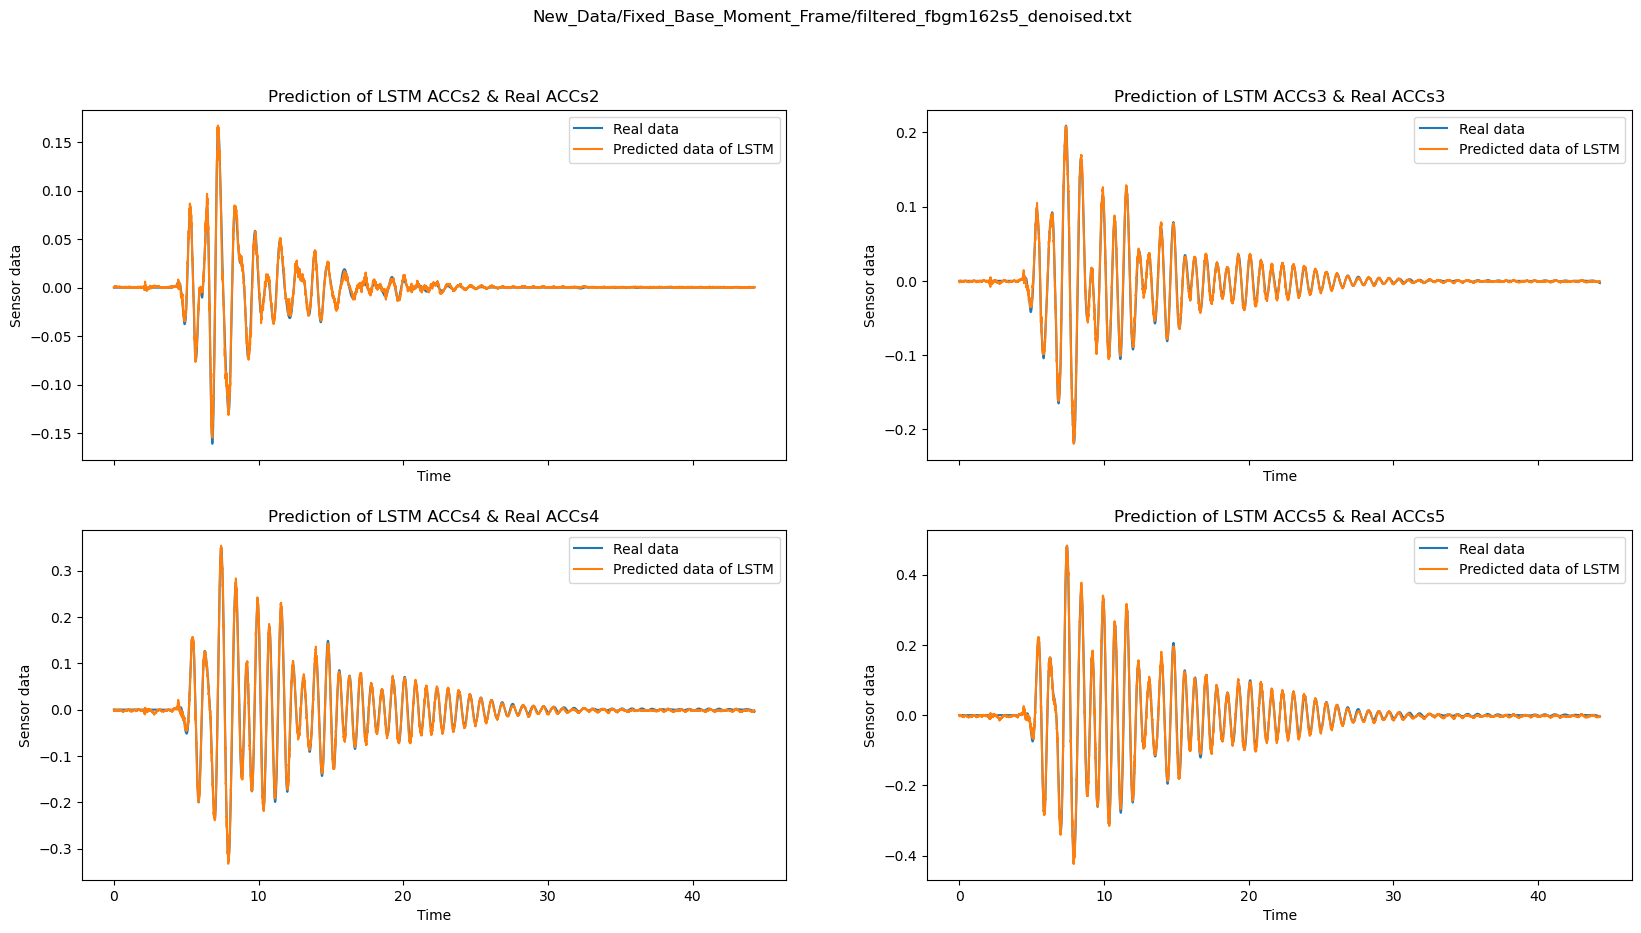

MSE Loss: 2.1892245058552362e-05


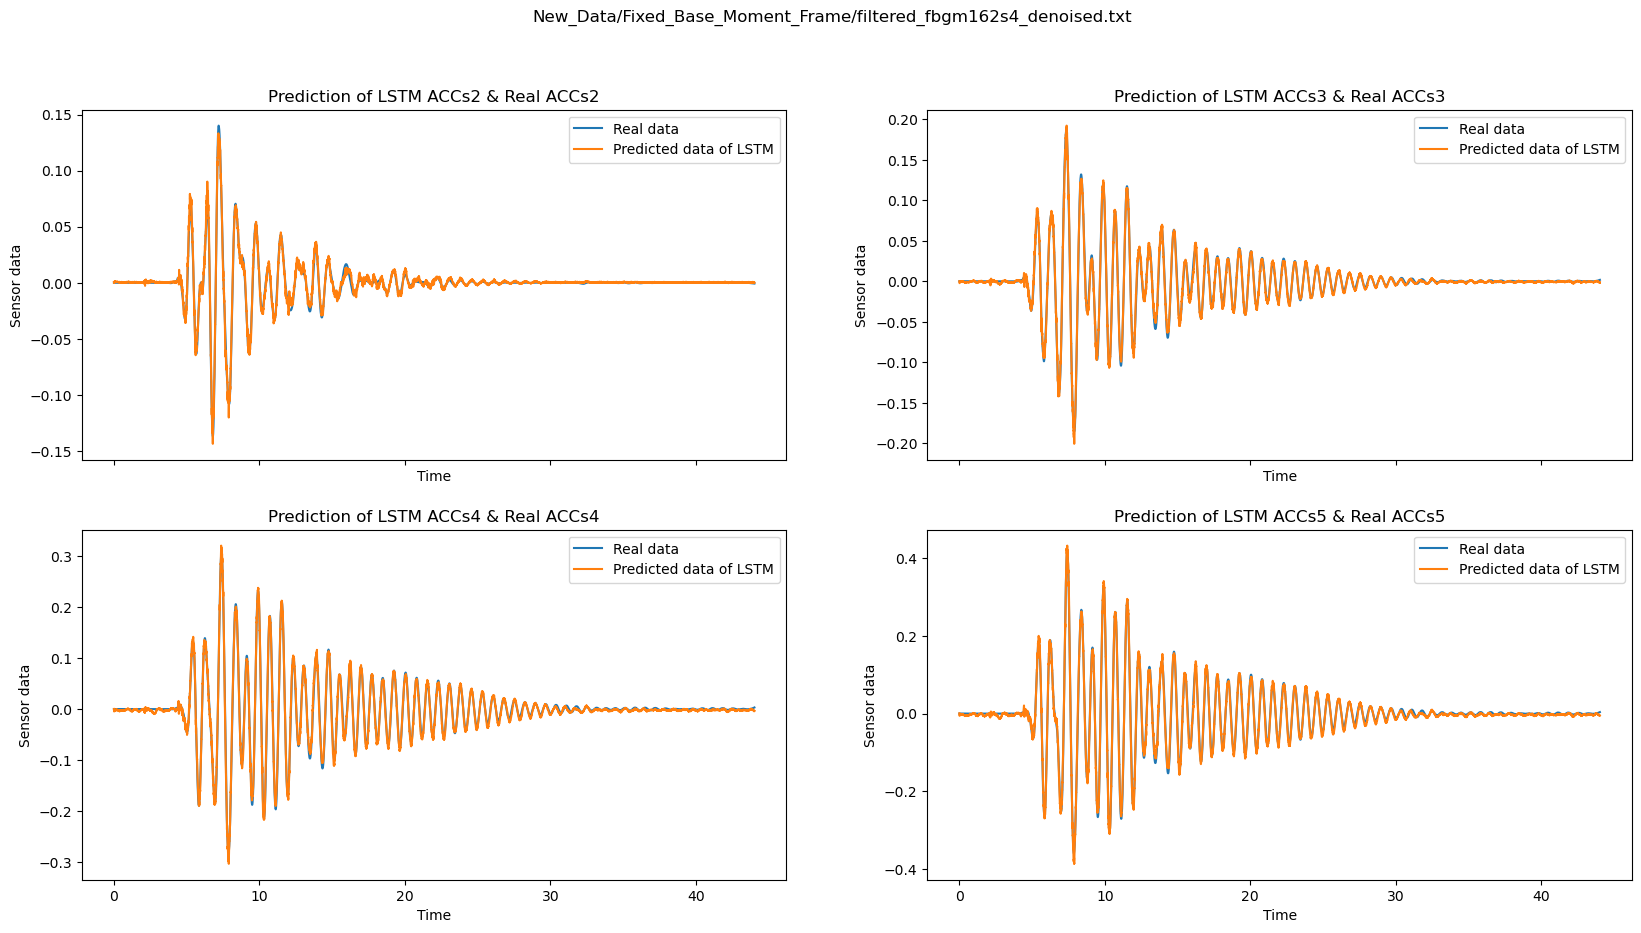

Plots for unseen data
File excluded from training data - filtered_fbgm162s1_denoised.txt
MSE Loss: 0.00022917610476724803


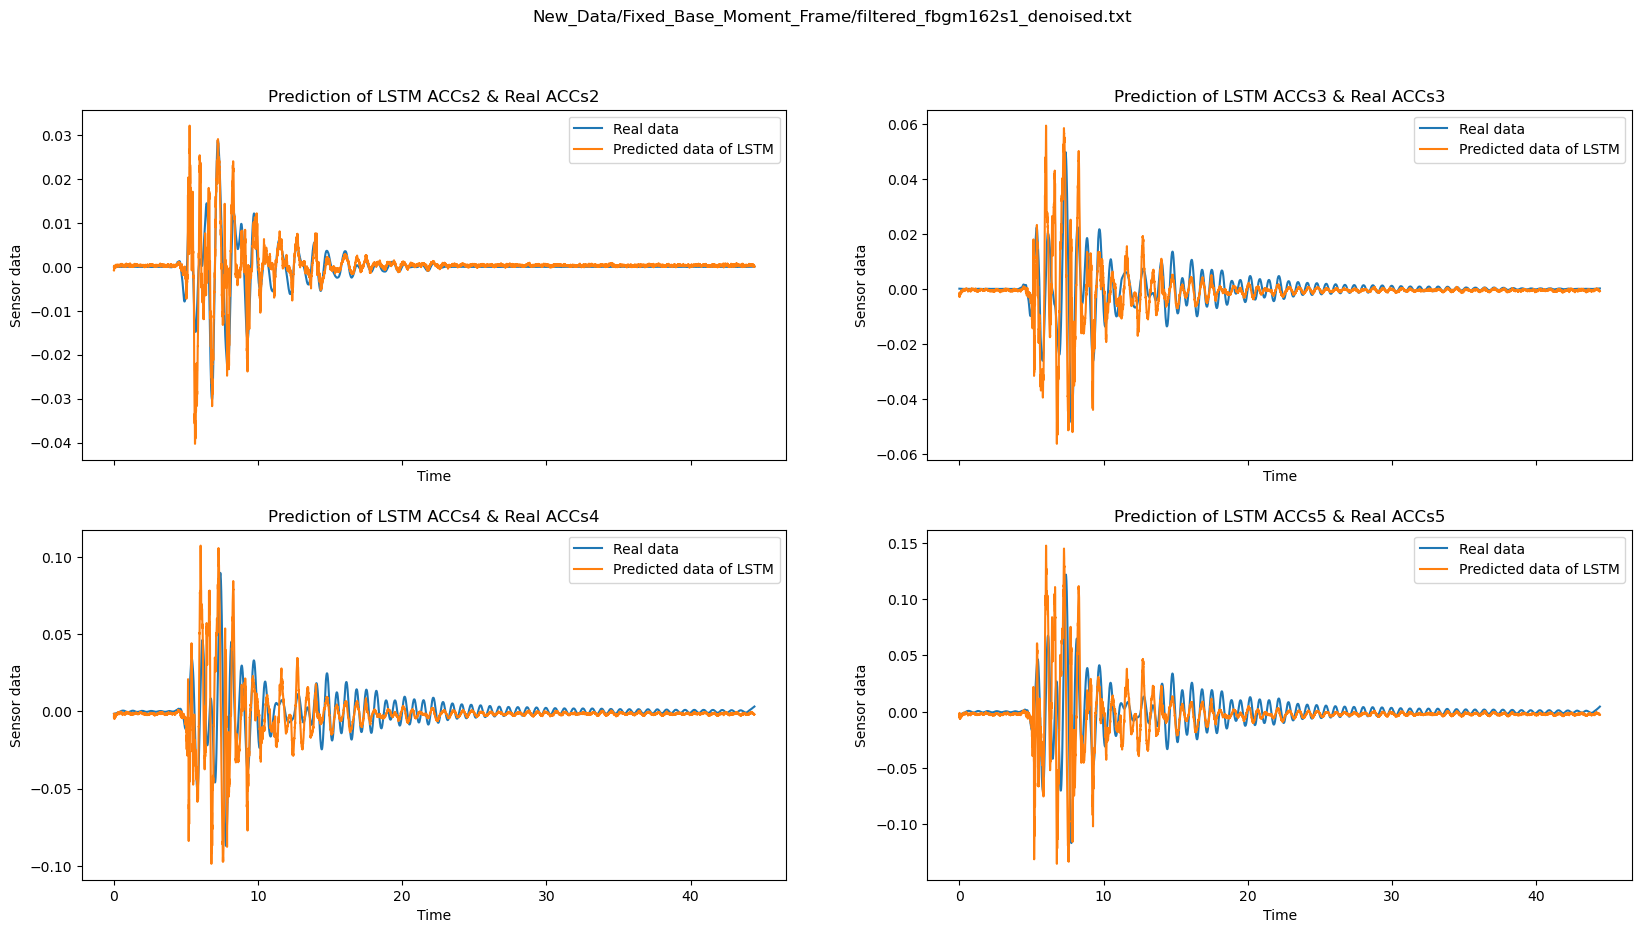

In [16]:
print("Plot the predictions with the best model from grid search")
with torch.no_grad():
    print("Plots for seen data")
    for df, file_name in all_data:
        plot_results(best_model, df, folder_path, file_name, device)

    print("Plots for unseen data")
    print(f"File excluded from training data - {file_valid}")
    plot_results(best_model, df_valid, folder_path, file_valid, device)
    